In [1]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter

import time
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

import re
import os
import scipy
import scipy.stats as stats
from statsmodels.stats.multitest import *

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.pangenome_cmds import *
from PseudoFind.functional_annotations import *

import matplotlib
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
FTSA = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
fasta_files = list(FTSA['Directory'])
FTPA = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f3.csv', dtype = {'Genome ID':str})
fasta_files += ['/home/yara/Documents/cystic_fibrosis/data/pseudomonas/prokka/%s/%s.faa'%(x,x) for x in FTPA['Genome ID']]

no_CDS = {}
for fa in fasta_files:
    with open(fa, 'r') as f:
        string = f.read()
    no_CDS[fa.split('/')[-1].split('.f')[0].replace('_m','')] = len(string.split('\n>'))
FTPA['CDS (PROKKA)'] = [no_CDS[x] for x in FTPA['Genome ID']]
FTSA['CDS (PROKKA)'] = [no_CDS[x] for x in FTSA['Genome ID']]
FTSA['GC Content'] = FTSA['GC content']*100

In [153]:
def get_codon_usage(fasta):
    with open(fasta, 'r') as f:
        string = f.read()
    gid = fasta.split('/')[-1].split('.f')[0]
    return {gid:  Counter([''.join(x.split('\n')[1:])[:-1][i-3:i] for x in string.split('\n>') if 'tRNA' not in x for i in range(3, len(''.join(x.split('\n')[1:])[:-1]), 3)])  }



In [152]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return round(abs(u1 - u2) / s,2)


In [2]:
# var1: cf, var2: noncf
def get_density_plot(ax, var1, var2):
    i = 0
    for color, var in {'indianred':var1, 'darkblue': var2}.items():
        kde_ = sns.distplot(var, hist=False, kde=True, norm_hist = False, 
                     bins=10, color = color, 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 1}, ax = ax )

        l1 = kde_.lines[i]
        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]
        ax.fill_between(x1,y1, color=color, alpha=0.3)
        i += 1
        
    plt.legend(handles = [mpatches.Patch(color = 'indianred', label = 'Cystic Fibrosis'), mpatches.Patch(color = 'darkblue', label = 'Other')])

# average CDS length - nothing of interest (thankfully!)

In [96]:
from multiprocessing import Pool, TimeoutError
from functools import partial
import multiprocessing

In [12]:
def get_seqlengths(fasta):
    with open(fasta, 'r') as f:
        string = f.read()
    gid = fasta.split('/')[-1].split('.fa')[0]
    return {gid:[len(''.join(x.split('\n')[1:])) for x in string.split('\n>')]}

In [133]:
# pool = multiprocessing.Pool(processes = 4)
# func = partial(get_seqlengths)
# params_df = pool.map(func, fasta_files)        
# pool.close()
# PA_lengths = {list(z.keys())[0].replace('_m',''):list(z.values())[0] for z in params_df}

Text(0.5, 1.0, 'Staphylococcus')

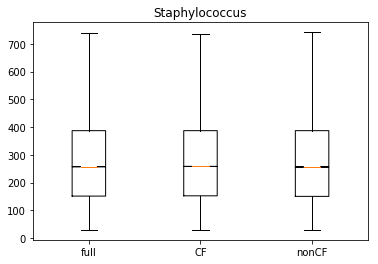

In [46]:
d = {'full': FTSA['Genome ID'].tolist(), 'CF':FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}
# to_plot = [[y for x in gids for y in PA_lengths[x]] for gids in d.values()]
plt.boxplot(to_plot, d.keys(), showfliers = False)
plt.xticks([1,2,3], d.keys())
plt.title('Staphylococcus')

Text(0.5, 1.0, 'Pseudomonas')

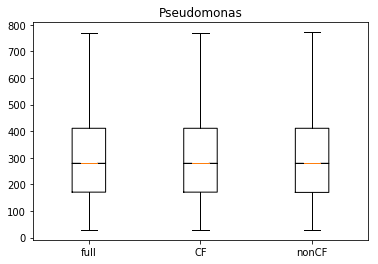

In [47]:
d = {'full': FTPA['Genome ID'].tolist(), 'CF':FTPA.loc[FTPA['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': FTPA.loc[FTPA['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}
to_plot = [[y for x in gids for y in PA_lengths[x]] for gids in d.values()]
plt.boxplot(to_plot, d.keys(), showfliers = False)
plt.xticks([1,2,3], d.keys())
plt.title('Pseudomonas')

In [54]:
scipy.stats.mannwhitneyu([y for x in d['nonCF'] for y in PA_lengths[x]], [y for x in d['CF'] for y in PA_lengths[x]])

MannwhitneyuResult(statistic=824485761708.0, pvalue=1.6284343403117584e-12)

Text(0.5, 1.0, 'staph')

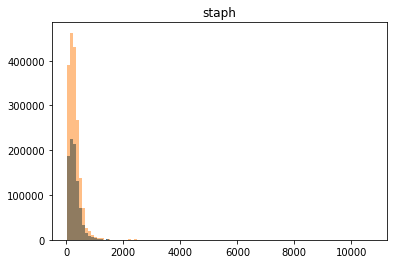

In [55]:
plt.hist([y for x in d['CF'] for y in PA_lengths[x]], bins = 100)
plt.hist([y for x in d['nonCF'] for y in PA_lengths[x]], bins = 100, alpha = 0.5)
plt.title('staph')

Text(0.5, 1.0, 'n')

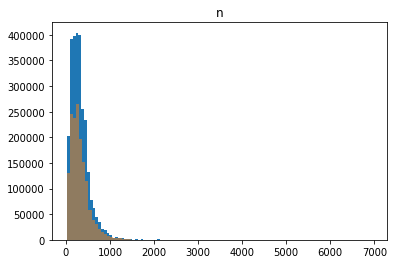

In [51]:
plt.hist([y for x in d['CF'] for y in PA_lengths[x]], bins = 100)
plt.hist([y for x in d['nonCF'] for y in PA_lengths[x]], bins = 100, alpha = 0.5)
plt.title('n')

# amino acid composition

In [205]:
def get_amino_acid_composition(fasta):
    with open(fasta, 'r') as f:
        string = f.read()
    gid = fasta.split('/')[-1].split('.fa')[0]
    return {gid:  dict(Counter(''.join([''.join(x.split('\n')[1:]) for x in string.split('\n>')])))  }

In [1093]:
pool = multiprocessing.Pool(processes = 4)
func = partial(get_amino_acid_composition)
params_df_aa = pool.map(func, fasta_files)        
pool.close()
amino_acid_composition = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df_aa}).fillna(0)
amino_acid_composition = amino_acid_composition/amino_acid_composition.sum()

In [1309]:
pickle.dump(params_df_aa, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/params_df_amino_acid_compositione.p', 'wb'))

In [134]:
params_df_aa = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/params_df_amino_acid_compositione.p', 'rb'))
amino_acid_composition = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df_aa}).fillna(0)
amino_acid_composition = amino_acid_composition.drop(['X'])
amino_acid_composition = 100*amino_acid_composition/amino_acid_composition.sum()

In [135]:
res = []
for codon in amino_acid_composition.index:
    var1 = amino_acid_composition[FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
    var2 = amino_acid_composition[FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
    statistic, pval = scipy.stats.mannwhitneyu(var1, var2)
    res.append({'statistic':statistic, 'pval':pval, 'AA':codon})
pd.DataFrame(res).sort_values(by = 'pval').head(3)

,AA,pval,statistic
14,R,1.428878e-73,37390.0
9,L,4.717068e-41,58983.0
3,E,6.703590e-34,64845.0


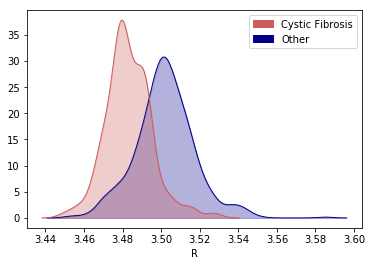

In [72]:
codon = 'R'
var1 = amino_acid_composition[FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
var2 = amino_acid_composition[FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
fig, ax = plt.subplots(1,1)
get_density_plot(ax, var1, var2)

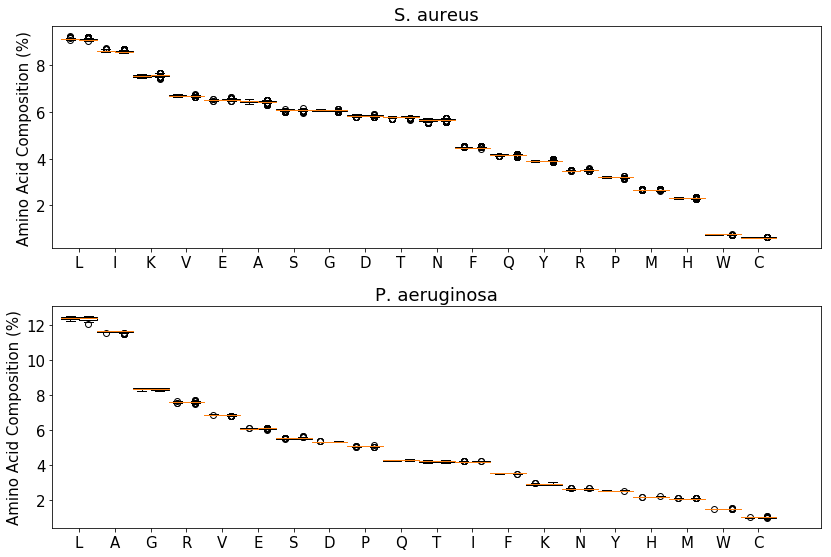

In [141]:
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

i = 0

for spe, FT_o in {'P. aeruginosa':FTPA, 'S. aureus':FTSA}.items():
    ax = axes[i]
    AA_sorted = amino_acid_composition[FT_o['Genome ID']].mean(axis = 1).sort_values(ascending = False).index
    FTPA_CF = FT_o.loc[FT_o['cystic_fibrosis_status'] == 1]
    ax.boxplot([amino_acid_composition[FTPA_CF['Genome ID']].loc[index] for index in AA_sorted], positions = range(1, len(amino_acid_composition)+1))

    FTPA_nonCF = FT_o.loc[FT_o['cystic_fibrosis_status'] == 0]
    ax.boxplot([amino_acid_composition[FTPA_nonCF['Genome ID']].loc[index] for index in AA_sorted], positions = [i+0.5 for i in range(1, len(amino_acid_composition)+1)])

    ax.set_xlim(0.5, 22)
    ax.set_xticks([i+0.25 for i in range(1, len(amino_acid_composition)+1)])
    ax.set_xticklabels(AA_sorted)
    ax.set_ylabel('Amino Acid Composition (%)')
    ax.set_title(spe)
    
    i += 1
    
plt.tight_layout()

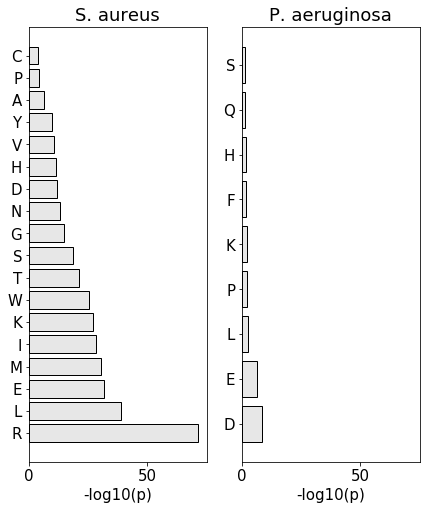

In [142]:
amino_acid_composition = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df_aa}).fillna(0)
amino_acid_composition = amino_acid_composition.drop(['X'])
amino_acid_composition = 100*amino_acid_composition/amino_acid_composition.sum()
# amino_acid_composition = amino_acid_composition.T

fig, axes = plt.subplots(1,2 , sharex = True, sharey = False, figsize = (7, 8))
i = 0
for spe, FT in {'P. aeruginosa':FTPA, 'S. aureus':FTSA}.items():
    
    ax = axes[i]
    res = []
    
    for codon in amino_acid_composition.index:
        var1 = amino_acid_composition[FT.loc[FT['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
        var2 = amino_acid_composition[FT.loc[FT['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
        statistic, pval = scipy.stats.mannwhitneyu(var1, var2)
        effect_size = cohend(var1, var2)
        res.append({'statistic':statistic, 'pval':pval,'AA':codon, 'Difference %':round(100*(1-np.mean(var1)/np.mean(var2)), 2),
                   'Effect size':effect_size})
            
    codon_bias_res = pd.DataFrame(res).sort_values(by = 'pval', ascending=False)

    codon_bias_res = codon_bias_res.loc[codon_bias_res['Effect size'] > 0.2]
    methods = ['bonferroni', 'fdr_bh', 'fdr_tsbky']
    reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(codon_bias_res['pval'], alpha = 0.05, method = methods[0], is_sorted = False, returnsorted=False)
    
    codon_bias_res['p-val (%s correction)'%methods[0]] = pvals_corrected
    codon_bias_res['rejected (%s correction)'] = reject
    codon_bias_res['log10 pval corrected'] = -np.log10(codon_bias_res['p-val (%s correction)'%methods[0]])
    
    
    # only pllotting the not rejected instances:
    cc = codon_bias_res.loc[reject]
    counter = OrderedDict(sorted({aa:max(cc.loc[cc['AA'] == aa]['log10 pval corrected']) for aa in set(cc['AA'])}.items(), key = lambda a: a[1], reverse = True))
#     counter = OrderedDict(sorted({aa:max(cc.loc[cc['AA'] == aa]['Effect size']) for aa in set(cc['AA'])}.items(), key = lambda a: a[1], reverse = True))
    
    ax.barh(range(len(counter)), list(counter.values()),  color=(0.1, 0.1, 0.1, 0.1),  edgecolor='black')
    ax.set_yticks(range(len(counter)))
    ax.set_yticklabels(counter.keys())
    ax.set_title(spe)
    i += 1
    ax.set_xlabel('-log10(p)')
    

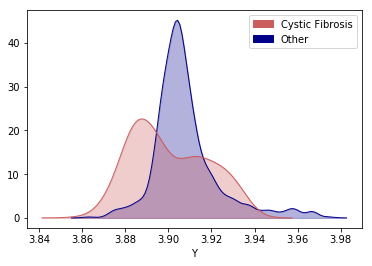

In [61]:
fig, ax = plt.subplots(1,1)
gids1, gids2 = FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID'], FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']
var1, var2 = amino_acid_composition.loc['Y', gids1], amino_acid_composition.loc['Y', gids2]
get_density_plot(ax, var1, var2)

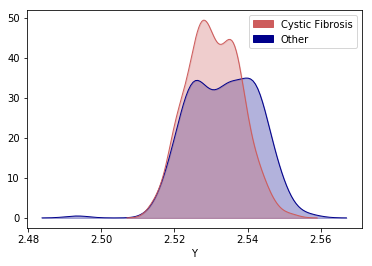

In [62]:
fig, ax = plt.subplots(1,1)
gids1, gids2 = FTPA.loc[FTPA['cystic_fibrosis_status'] == 1]['Genome ID'], FTPA.loc[FTPA['cystic_fibrosis_status'] == 0]['Genome ID']
var1, var2 = amino_acid_composition.loc['Y', gids1], amino_acid_composition.loc['Y', gids2]
get_density_plot(ax, var1, var2)

Text(0.5, 1.0, 'PCA of MIC profiles')

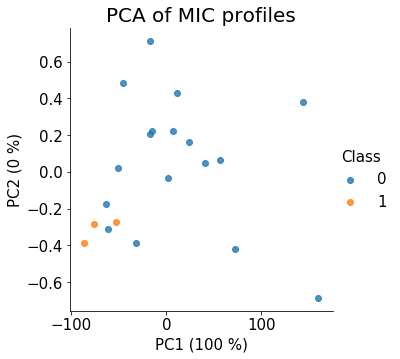

In [144]:
from sklearn.decomposition import PCA
from PseudoFind.ML_library import *

ft = FTPA
to_study = amino_acid_composition[ft['Genome ID']]
d = ft.set_index('Genome ID')['cystic_fibrosis_status'].to_dict()

pca = PCA().fit(to_study)
summary = pca_summary(pca, to_study, out = False)

# d = {x:'S. aureus' for x in FTPA['Genome ID']}
# d.update({x:'P. aeruginosa' for x in FTPA['Genome ID']})

classifs = [d[x.replace('_m','')] for x in to_study.columns]

foo = pca.transform(to_study)
bar = pd.DataFrame(list(zip(foo[:, 0], foo[:, 1], classifs)), columns=["PC1", "PC2", "Class"])
sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)
pc1 = int(round(summary['cumprop']['Cumulative Proportion'][0]*100,0))
pc2 = int(round(summary['cumprop']['Cumulative Proportion'][1]*100,0)) - pc1
plt.xlabel('PC1 (%d %%)'%(pc1), fontsize = 15)
plt.ylabel('PC2 (%d %%)'%(pc2),fontsize = 15)
plt.title('PCA of MIC profiles', fontsize = 20)

In [1272]:
len(pca.components_[0])

712

# codon usage bias

In [369]:

ffn_files = [x.replace('_m','').replace('.faa','.ffn') for x in fasta_files]
pool = multiprocessing.Pool(processes = 4)
func = partial(get_codon_usage)
params_df = pool.map(func, ffn_files)        
pool.close()
codon_usage = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df}).fillna(0)
# pickle.dump(params_df, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/params_df_codon_udage.p', 'wb'))

codon_usage = codon_usage.drop([index for index in codon_usage.index if 'N' in index])
# amino_acid_composition = amino_acid_composition/amino_acid_composition.sum()

# slight issue here is that tRNAs are also taken into consideration, i.e. not only CDSs. 

In [145]:
params_df = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/params_df_codon_udage.p', 'rb'))
codon_usage = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df}).fillna(0)
codon_usage = codon_usage.drop([index for index in codon_usage.index if 'N' in index])

In [146]:
translation = {'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 'CTT':'L', 'CTC':'L',
'CTA':'L', 'CTG':'L', 'ATT':'I', 'ATC':'I', 'ATA':'I', 'ATG':'M',
'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V', 'TCT':'S', 'TCC':'S',
'TCA':'S','TCG':'S','CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P',
'ACT':'T','ACC':'T','ACA':'T','ACG':'T','GCT':'A','GCC':'A','GCA':'A',
'GCG':'A','TAT':'Y','TAC':'Y','TAA':'stop','TAG':'stop', 'CAT':'H',
'CAC':'H', 'CAA':'Q','CAG':'Q','AAT':'N','AAC':'N','AAA':'K','AAG':'K',
'GAT':'D','GAC':'D','GAA':'E','GAG':'E','TGT':'C','TGC':'C','TGA':'stop',
'TGG':'W','CGT':'R','CGC':'R','CGA':'R','CGG':'R','AGT':'S','AGC':'S',
'AGA':'R','AGG':'R','GGT':'G','GGC':'G','GGA':'G','GGG':'G'}
translation_rev = defaultdict(list)
for x,y in translation.items():
    translation_rev[y].append(x)

{'boxes': [<matplotlib.lines.Line2D at 0x7fbed2433080>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbed2433e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbed2449ba8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fbed24494a8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbed2433d30>,
  <matplotlib.lines.Line2D at 0x7fbed24512b0>]}

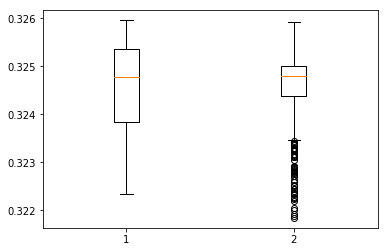

In [9]:
gc = [x for x in codon_usage.index if x[1] == 'G'] + [x for x in codon_usage.index if x[1] == 'C']
at = [x for x in codon_usage.index if x[1] == 'A'] + [x for x in codon_usage.index if x[1] == 'T']

gids = FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID']
GC3a = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())
gids = FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']
GC3b = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())
# fig, ax = plt.subplots(1,1)
plt.boxplot([GC3a, GC3b])

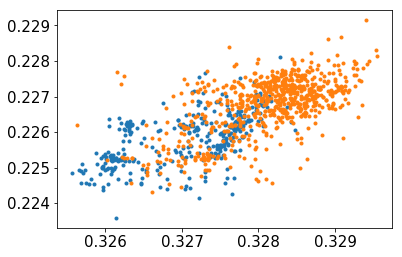

In [151]:
ft = FTSA
i = 2

gc = [x for x in codon_usage.index if x[i] == 'G'] + [x for x in codon_usage.index if x[i] == 'C']
at = [x for x in codon_usage.index if x[i] == 'A'] + [x for x in codon_usage.index if x[i] == 'T']
gids = ft.loc[ft['cystic_fibrosis_status'] == 1]['Genome ID']
GC3a = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())
gids = ft.loc[ft['cystic_fibrosis_status'] == 0]['Genome ID']
GC3b = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())

pval = round(scipy.stats.ttest_ind(GC3a, GC3b)[1], 3)

plt.plot(ft.loc[ft['cystic_fibrosis_status'] == 1]['GC Content']/100, GC3a,'.')
plt.plot(ft.loc[ft['cystic_fibrosis_status'] == 0]['GC Content']/100, GC3b,'.')

In [ ]:
# PMC3444174: guieline for effect sizes

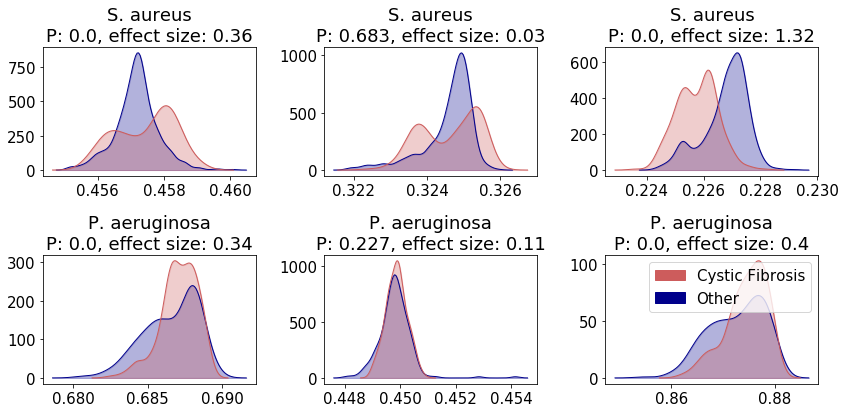

In [157]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))

j = 0
for spe, ft in {'P. aeruginosa':FTPA, 'S. aureus': FTSA}.items():
    for i in range(3):
        gc = [x for x in codon_usage.index if x[i] == 'G'] + [x for x in codon_usage.index if x[i] == 'C']
        at = [x for x in codon_usage.index if x[i] == 'A'] + [x for x in codon_usage.index if x[i] == 'T']
        gids = ft.loc[ft['cystic_fibrosis_status'] == 1]['Genome ID']
        GC3a = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())
        gids = ft.loc[ft['cystic_fibrosis_status'] == 0]['Genome ID']
        GC3b = codon_usage[gids].loc[gc].sum()/(codon_usage[gids].loc[at].sum()+codon_usage[gids].loc[gc].sum())
        get_density_plot(axes[j,i], GC3a, GC3b)
        pval = round(scipy.stats.ttest_ind(GC3a, GC3b)[1], 3)
        effect_size = cohend(GC3a, GC3b)
        axes[j,i].set_title('%s\nP: %s, effect size: %s'%(spe, pval, effect_size))
        
    j += 1
        
plt.tight_layout()

CAA 0.024858501903217884


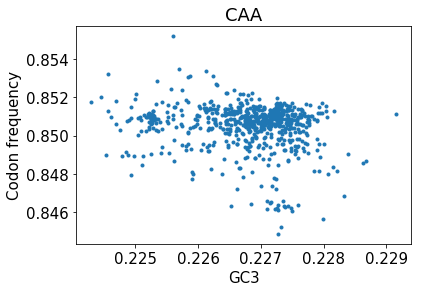

In [1265]:
gids = FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']

codon_usage = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df}).fillna(0)
codon_usage = codon_usage.drop([index for index in codon_usage.index if 'N' in index])[gids]
amino_acid_composition = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df_aa}).fillna(0)

B = FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['GC Content']/100
for codon in codon_usage.index:
    codon = 'CAA'
    # GC3 = codon_usage.loc[codon]/codon_usage.loc[translation_rev[translation[codon]]].sum()
    if codon.endswith('A') or codon.endswith('T'):
        if translation[codon] != 'stop' and len(translation_rev[translation[codon]]) == 2:
            codon_frequency = codon_usage.loc[codon]/amino_acid_composition[gids].loc[translation[codon]]
#             plt.figure()
            gc = [x for x in codon_usage.index if x.endswith('G')] + [x for x in codon_usage.index if x.endswith('C')]
            at = [x for x in codon_usage.index if x.endswith('A')] + [x for x in codon_usage.index if x.endswith('T')]
            GC3 = codon_usage.loc[gc].sum()/(codon_usage.loc[at].sum()+codon_usage.loc[gc].sum())
            print(codon, scipy.stats.pearsonr(1-GC3, codon_frequency)[0]**2)

            plt.plot(GC3, codon_frequency,'.')
            plt.xlabel('GC3')
            plt.ylabel('Codon frequency')
#             plt.plot(GC3, 1-B, 'k')
            plt.title(codon)
            break

In [1109]:
GC3 = codon_usage.loc[codon]/codon_usage.loc[translation_rev[translation[codon]]].sum()

1208103.3      0.137785
1221453.3      0.812450
1235275.3      0.807083
1235276.3      0.806098
1235277.3      0.809306
1235278.3      0.806850
1280.12239     0.811990
1280.12288     0.812503
1280.12289     0.812554
1280.12290     0.813529
1280.12291     0.811603
1280.12292     0.813196
1280.12293     0.812434
1280.12294     0.812092
1280.12295     0.812648
1280.12296     0.812500
1280.12297     0.812526
1280.12298     0.813716
1280.12299     0.811995
1280.12300     0.811633
1280.12301     0.812070
1280.12302     0.812151
1280.12303     0.812417
1280.12304     0.813491
1280.12305     0.811812
1280.12306     0.812570
1280.12307     0.813560
1280.12308     0.810951
1280.12309     0.812140
1280.12310     0.813151
                 ...   
287.9346       0.137590
287.9347       0.126009
287.9376       0.140086
287.9846       0.129621
287.9847       0.142047
287.9848       0.141620
287.9849       0.137273
287.9851       0.132747
287.9875       0.141126
287.9882       0.131964
287.9892       0

In [159]:
codon_usage = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df}).fillna(0)
codon_usage = codon_usage.drop([index for index in codon_usage.index if 'N' in index])
for aa, tr in translation_rev.items():
    codon_usage.loc[tr] = codon_usage.loc[tr]/(codon_usage.loc[tr].sum()/len(tr))

gids = FTPA.loc[FTPA['cystic_fibrosis_status'] == 1]['Genome ID']

third_pos = {}
for two,codons in thirdpos_rev.items():
    third_pos[two] = {x[2]:y for x,y in dict(codon_usage[gids].loc[codons].sum(axis = 1)).items()}
GC3 = pd.DataFrame(third_pos).T[['A','T','C','G']]*100
sns.clustermap(GC3,cmap="mako_r")

NameError: name 'thirdpos_rev' is not defined

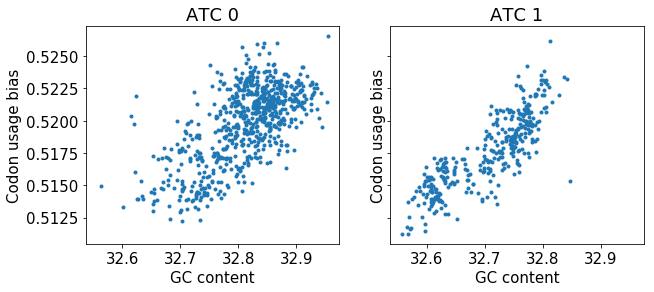

In [1086]:
ft = FTSA
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True, sharex = True)
for i in [0,1]:
    gids = ft.loc[ft['cystic_fibrosis_status'] == i]['Genome ID']
    codon = 'ATC'
    var1 = ft.set_index('Genome ID').loc[gids]['GC Content']
    var2 = codon_usage[gids].loc[codon]
    r, pval = scipy.stats.pearsonr(var1, var2)
    axes[i].plot(var1, var2,'.')
    axes[i].set_xlabel('GC content')
    axes[i].set_ylabel('Codon usage bias')
    axes[i].set_title('%s %d'%(codon, i))    

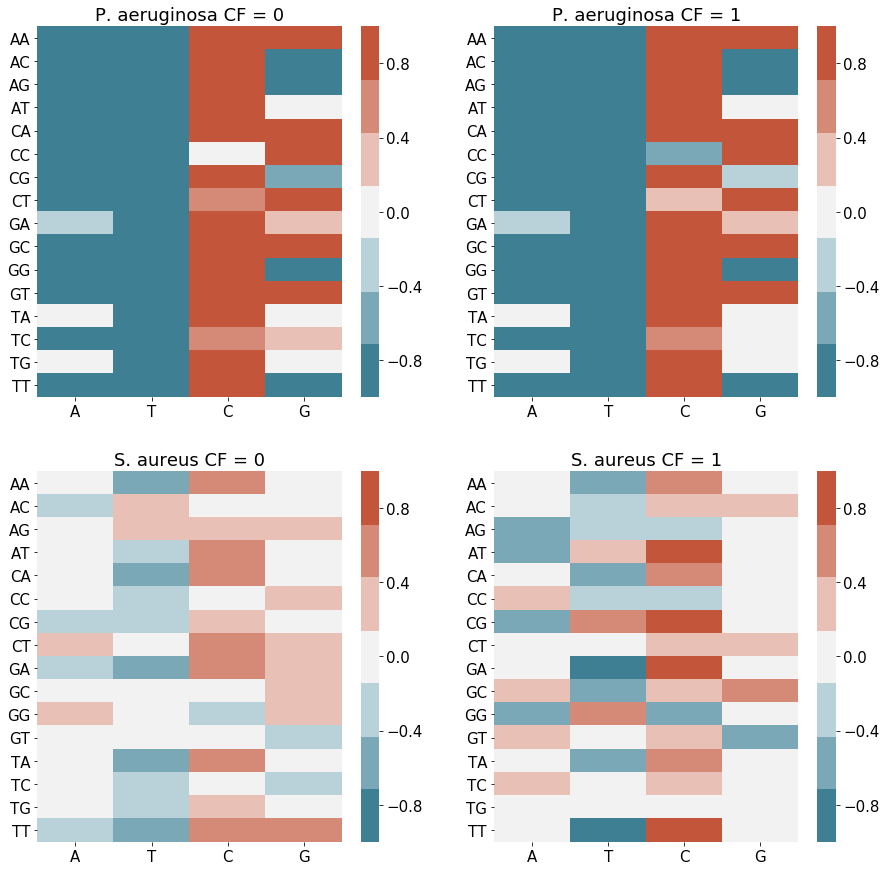

In [1088]:
fig, axes = plt.subplots(2,2, figsize = (15,15))

i = 0
for spe, ft in {'S. aureus': FTSA, 'P. aeruginosa':FTPA}.items():
    for j,cf in enumerate([0, 1]):
        gids = ft.loc[ft['cystic_fibrosis_status'] == cf]['Genome ID']

        third_pos = {}
        third_pos_corr = defaultdict(dict)
        for two,codons in thirdpos_rev.items():
        #     third_pos[two] = {x[2]:y for x,y in dict(codon_usage[gids].loc[codons].sum(axis = 1)/sum(codon_usage[gids].loc[codons].sum(axis = 1))).items()}
            for cod in codons:
                var1 = ft.set_index('Genome ID').loc[gids]['GC Content']
                var2 = codon_usage[gids].loc[cod]
                r, pval = scipy.stats.pearsonr(var1, var2)
                third_pos_corr[two][cod[-1]] = r

        GC3 = pd.DataFrame(third_pos_corr).T[['A','T','C','G']].fillna(0) #*100
        sns.heatmap(GC3,cmap=sns.diverging_palette(220, 20, n=7), ax = axes[i,j],vmin = -1, vmax = 1, center = 0)
        axes[i,j].set_title('%s CF = %d'%(spe, cf))
    i += 1

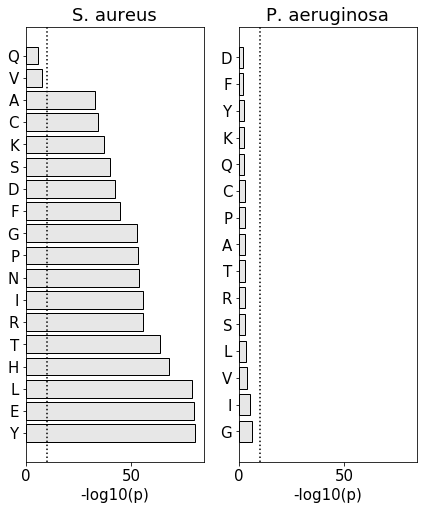

In [188]:
codon_usage = pd.DataFrame({list(x.keys())[0].replace('_m',''):dict((list(x.values())[0] )) for x in params_df}).fillna(0)
codon_usage = codon_usage.drop([index for index in codon_usage.index if 'N' in index])
for aa, tr in translation_rev.items():
    codon_usage.loc[tr] = codon_usage.loc[tr]/(codon_usage.loc[tr].sum()/len(tr))
    
fig, axes = plt.subplots(1,2 , sharex = True, sharey = False, figsize = (7, 8))
i = 0
res_all = []
for spe, FT in {'P. aeruginosa':FTPA, 'S. aureus':FTSA}.items():
    
    ax = axes[i]
    res = []
    
    for codon in codon_usage.index:
        if translation[codon] not in ['stop', 'M', 'W']:
            var1 = codon_usage[FT.loc[FT['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
            var2 = codon_usage[FT.loc[FT['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
            statistic, pval = scipy.stats.mannwhitneyu(var1, var2)
            effect_size = cohend(var1, var2)
            res.append({'statistic':statistic, 'pval':pval, 'codon':codon, 'AA':translation[codon], 
                        'Difference %':round(100*(1-np.mean(var1)/np.mean(var2)), 2),
                        'Effect size':effect_size, 'Species':spe
                       })
    res_all += res      
    codon_bias_res = pd.DataFrame(res).sort_values(by = 'pval', ascending=False)

    methods = ['bonferroni', 'fdr_bh', 'fdr_tsbky']
    reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(codon_bias_res['pval'], alpha = 0.05, method = methods[0], is_sorted = False, returnsorted=False)
    
    codon_bias_res['p-val (%s correction)'%methods[0]] = pvals_corrected
    codon_bias_res['rejected (%s correction)'] = reject
    codon_bias_res['log10 pval corrected'] = -np.log10(codon_bias_res['p-val (%s correction)'%methods[0]])
    
    # only pllotting the not rejected instances:
    cc = codon_bias_res.loc[reject]
    counter = OrderedDict(sorted({aa:max(cc.loc[cc['AA'] == aa]['log10 pval corrected']) for aa in set(cc['AA'])}.items(), key = lambda a: a[1], reverse = True))
#     counter = OrderedDict(sorted({aa:max(cc.loc[cc['AA'] == aa]['Effect size']) for aa in set(cc['AA'])}.items(), key = lambda a: a[1], reverse = True))
    
    
    ax.barh(range(len(counter)), list(counter.values()),  color=(0.1, 0.1, 0.1, 0.1),  edgecolor='black')
    ax.set_yticks(range(len(counter)))
    ax.set_yticklabels(counter.keys())
    ax.set_title(spe)
    i += 1
    ax.set_xlabel('-log10(p)')
    ax.axvline(10, linestyle = 'dotted', color ='black')

In [176]:
codon_bias_res = pd.DataFrame(res_all).sort_values(by = 'pval', ascending=False)

methods = ['bonferroni', 'fdr_bh', 'fdr_tsbky']
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(codon_bias_res['pval'], alpha = 0.05, method = methods[0], is_sorted = False, returnsorted=False)

codon_bias_res['p-val (%s correction)'%methods[0]] = pvals_corrected
codon_bias_res['rejected (%s correction)'] = reject
codon_bias_res['log10 pval corrected'] = -np.log10(codon_bias_res['p-val (%s correction)'%methods[0]])

# only pllotting the not rejected instances:
codon_bias_res = codon_bias_res.loc[reject]

In [182]:
codon_bias_res.loc[codon_bias_res['Species'] == 'S. aureus'].sort_values(by = 'Effect size', ascending = False).head(2)

,AA,Difference %,Effect size,Species,codon,pval,statistic,p-val (bonferroni correction),rejected (%s correction),log10 pval corrected
47,Y,1.24,1.55,S. aureus,TAC,8.014822e-83,32207.5,9.457490e-81,True,80.024224
48,Y,-0.35,1.55,S. aureus,TAT,8.014822e-83,32207.5,9.457490e-81,True,80.024224


In [181]:
codon_bias_res.loc[codon_bias_res['Species'] == 'P. aeruginosa'].sort_values(by = 'Effect size', ascending = False).head(2)

,AA,Difference %,Effect size,Species,codon,pval,statistic,p-val (bonferroni correction),rejected (%s correction),log10 pval corrected
100,G,0.65,0.54,P. aeruginosa,GGG,2.108576e-08,19188.0,0.000002,True,5.604129
71,I,3.35,0.50,P. aeruginosa,ATA,1.446937e-07,19700.0,0.000017,True,4.767668


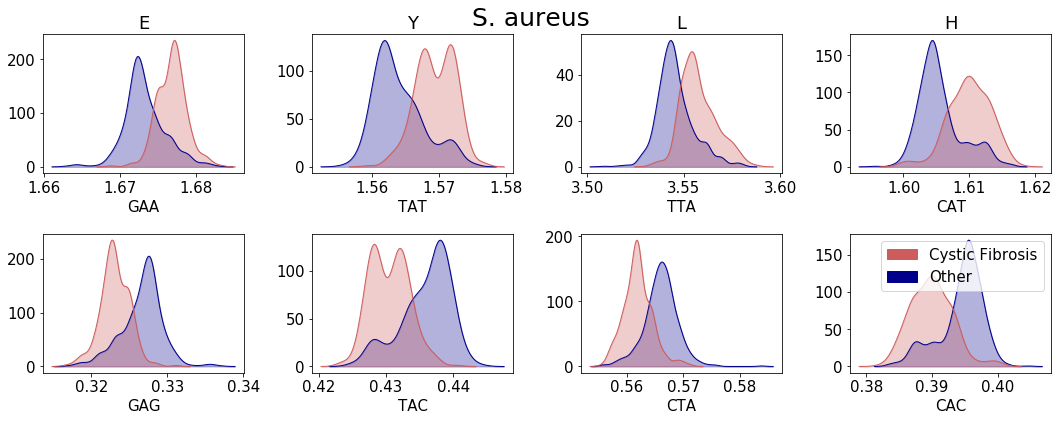

In [161]:
fig, axes = plt.subplots(2,4, figsize = (15, 6))

for i, codons in enumerate([['GAA', 'GAG'], ['TAT','TAC'], ['TTA','CTA'], ['CAT','CAC'] ]):
    axes[0,i].set_title(translation[codons[0]])
    for j, codon in enumerate(codons):
        ax = axes[j, i]
        var1 = codon_usage[FTSA.loc[FTSA['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
        var2 = codon_usage[FTSA.loc[FTSA['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
        get_density_plot(ax, var1, var2)
        ax.set_xlabel(codon)

fig.suptitle('S. aureus', fontsize= 25)
fig.subplots_adjust(top=1.5)
fig.tight_layout()


In [870]:
res = []
for codon in codon_usage.index:
    var1 = codon_usage[FTPA.loc[FTPA['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
    var2 = codon_usage[FTPA.loc[FTPA['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
    statistic, pval = scipy.stats.ks_2samp(var1, var2)
    res.append({'statistic':statistic, 'pval':pval, 'codon':codon, 'AA':translation[codon]})
pd.DataFrame(res).sort_values(by = 'pval').head(8)

,AA,codon,pval,statistic
42,G,GGG,2.546294e-18,0.351563
60,L,TTA,6.441000e-17,0.337500
11,S,AGT,3.402089e-16,0.330021
7,T,ACT,9.557136e-16,0.325293
53,S,TCC,1.302539e-14,0.313018
59,C,TGT,1.716043e-14,0.311694
57,C,TGC,1.716043e-14,0.311694
61,F,TTC,2.051200e-14,0.310835


In [877]:
pd.DataFrame(res).sort_values(by = 'pval').iloc[-6:]

,AA,codon,pval,statistic
21,P,CCC,0.045123,0.106643
58,W,TGG,1.000000,0.000000
56,stop,TGA,1.000000,0.003507
48,stop,TAA,1.000000,0.011381
14,M,ATG,1.000000,0.000000
50,stop,TAG,1.000000,0.011811


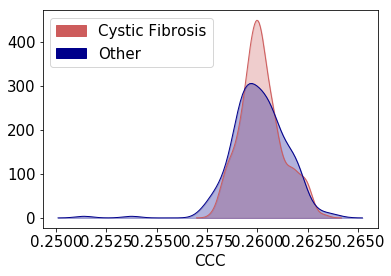

In [878]:
codon = 'CCC'
fig, ax = plt.subplots(1,1)
var1 = codon_usage[FTPA.loc[FTPA['cystic_fibrosis_status'] == 1]['Genome ID']].loc[codon]
var2 = codon_usage[FTPA.loc[FTPA['cystic_fibrosis_status'] == 0]['Genome ID']].loc[codon]
get_density_plot(ax, var1, var2)

# genome reduction

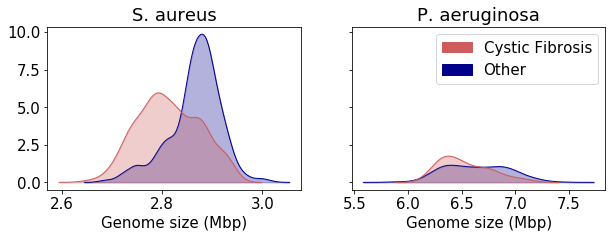

In [163]:
avg_diff = {}
fig, axes = plt.subplots(1,2, figsize = (10, 3), sharey = True)
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})


no = 120

metadata = [{'title':'S. aureus', 'FT':FTSA, 'col':'Sequence length', 'spe':'staphylococcus','xlim':(32, 33.5)},
            {'title':'P. aeruginosa', 'FT':FTPA, 'col':'Genome Length', 'spe':'pseudomonas', 'xlim':(65.5, 67)}
           ]
i = 0
for d in metadata:
    
    SoI_FT = d['FT']
    var1, var2 = SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1][d['col']]/10**6, SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0][d['col']]/10**6
    statistic, pval = scipy.stats.mannwhitneyu(var1, var2) 
    
    gene1, gene2 = SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['CDS (PROKKA)'], SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['CDS (PROKKA)']
    gene_diff = np.mean(gene2) - np.mean(gene1)

    pan_CF = pd.read_csv( '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_sample_%s.csv'%(d['spe'], 'CF'), index_col = ['Unnamed: 0'])
    pan_nonCF = pd.read_csv( '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_sample_%s.csv'%(d['spe'], 'nonCF'), index_col = ['Unnamed: 0'])
    pan_diff = str(int(np.average(pan_nonCF.iloc[no])) - int(np.average(pan_CF.iloc[no])))
    pan_diff_perc = str(round(100*(1-np.average(pan_CF.iloc[no])/np.average(pan_nonCF.iloc[no])),1))
    
    diff_l = 10**3*(np.mean(var2) - np.mean(var1))
    avg_diff[d['spe']] = {'Difference in no. genes': '%s (%s %%)'%(str(int(gene_diff)), str(round(100*gene_diff/np.mean(gene2),1))),
                        'Mann-WhitneyU': 'p = %s, statistic = %s'%(str(round(pval,3)), str(statistic)),
                     'Difference in pan genome size (n = no)':'No. genes = %s (%s %%)'%(pan_diff, pan_diff_perc),
                         'Difference in genome length':'%s Kbp (%s %%)'%(str(round(diff_l)), str(round(100*diff_l*10**3/np.mean(SoI_FT[d['col']]),1))),
                          'Effect size':cohend(var1, var2)
                         }    

    get_density_plot(axes[i], var1, var2)
    axes[i].set_title(d['title'])
    axes[i].set_xlabel('Genome size (Mbp)')

    i += 1

pd.DataFrame(avg_diff).T

fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/genome_sizes.svg')

In [164]:
round(pd.DataFrame(avg_diff),3)

,pseudomonas,staphylococcus
Difference in genome length,109.0 Kbp (1.7 %),52.0 Kbp (1.8 %)
Difference in no. genes,101 (1.7 %),55 (2.1 %)
Difference in pan genome size (n = no),No. genes = 2063 (11.6 %),No. genes = 180 (4.2 %)
Effect size,0.41,0.94
Mann-WhitneyU,"p = 0.0, statistic = 21024.0","p = 0.0, statistic = 62174.0"


# GC content

In [ ]:
# # SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
# # scipy.stats.ttest_ind(SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['GC content'] , SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['GC content'])

# SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str})
# pseudomonas_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT.csv')
# pseudomonas_FT['Sequencing Depth'] = [str(x).lower().replace('x','').replace('nan','').replace(',','.') for x in pseudomonas_FT['Sequencing Depth']]
# pseudomonas_FT = pseudomonas_FT.loc[pseudomonas_FT['Sequencing Depth'] != '']
# pseudomonas_FT['Sequencing Depth'] = [float(x) for x in pseudomonas_FT['Sequencing Depth']]
# pseudomonas_FT = pseudomonas_FT.loc[(pseudomonas_FT['Coarse Consistency'] > 0.97) & (pseudomonas_FT['Contigs'] <150) & (pseudomonas_FT['GC Content'] > 10) &  (pseudomonas_FT['Sequencing Depth'] > 10)]
# GC_random = random.sample(list(pseudomonas_FT['GC Content']/100), 500)

# stat, pval = scipy.stats.ttest_ind(GC_random , SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['GC Content'])
# plt.hist(SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['GC Content']/100, bins = 100, label = 'Cystic fibrosis')
# plt.hist(GC_random , bins = 100, label = 'Other', alpha = 0.3)

# plt.legend()
# plt.title('GC content (stat %s pval %s)'%(str(round(stat, 1)), str(round(pval, 3))))

In [83]:
# Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.
scipy.stats.bartlett(var1, var2)

BartlettResult(statistic=99.32373567829352, pvalue=2.1442272557149284e-23)

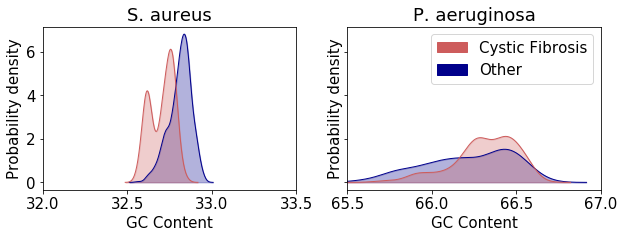

In [165]:
metadata = [{'title':'S. aureus', 'FT':FTSA,'xlim':(32, 33.5)},
            {'title':'P. aeruginosa', 'FT':FTPA, 'xlim':(65.5, 67)}
           ]
GC_diff = {}

matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, figsize = (10, 3), sharey = True)
i = 0
for d in metadata:
    SoI_FT = d['FT']
    var1, var2 = SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['GC Content'], SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['GC Content']
    gc_diff = round(np.mean(var2) - np.mean(var1),2)
    stat, pval = scipy.stats.mannwhitneyu(var1, var2)
    GC_diff[d['title']] = {'Difference in GC content (%)':gc_diff,
                                'Mann-Whitney U':'p = %s; statistic = %s'%(round(pval,4), round(stat,2)),
                              'Effect size':cohend(var1, var2)
                          }
    
    get_density_plot(axes[i], var1, var2)
    axes[i].set_title(d['title'])
    axes[i].set_xlim(d['xlim'][0], d['xlim'][1])
    axes[i].set_ylabel('Probability density')

    i += 1
    
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/GC_variation.svg')

In [166]:
pd.DataFrame(GC_diff)

,P. aeruginosa,S. aureus
Difference in GC content (%),-0.1,0.11
Effect size,0.43,1.58
Mann-Whitney U,p = 0.0001; statistic = 21666.5,p = 0.0; statistic = 31834.0


In [169]:
import statsmodels.api as sm

In [170]:
def return_plot(ax, GC1, genome_length1, color):
    X = sm.add_constant(np.array(GC1))
    model = sm.OLS(np.array(genome_length1), X)
    ols_results = model.fit(cov_type='HC0')
    b,a = ols_results.params
    Xrange = np.linspace(min(GC1), max(GC1), 1000)
    ax.plot(Xrange, a*np.array(Xrange) + b, color = color, markersize = 10)
#     return /[a,b]

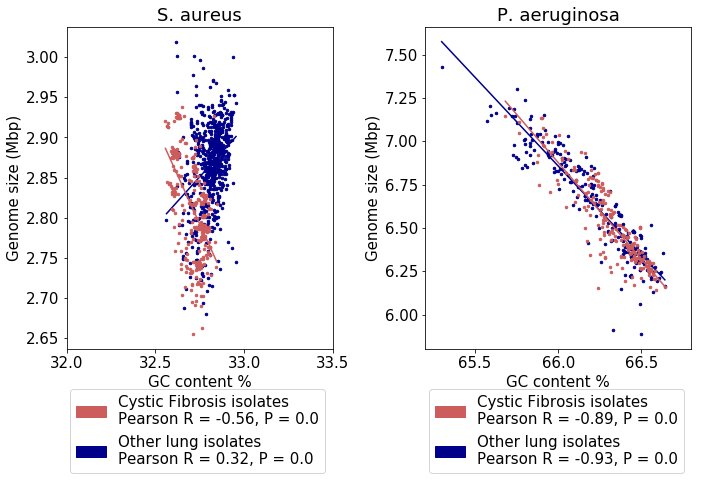

In [171]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})

fig, axes = plt.subplots(1,2 , figsize = (10, 7), sharey = False)
metadata = [{'title':'S. aureus', 'FT':FTSA, 'col':'Sequence length', 'spe':'staphylococcus','xlim':(32, 33.5)},
            {'title':'P. aeruginosa', 'FT':FTPA, 'col':'Genome Length', 'spe':'pseudomonas', 'xlim':(65.2, 66.8)}
           ]

pearson_res = {}
i = 0
for d in metadata:
    ax = axes[i]
    SoI_FT = d['FT']
    GC1, genome_length1 = SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['GC Content'], SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0][d['col']]/10**6
    GC2, genome_length2 = SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['GC Content'], SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1][d['col']]/10**6

    ax.plot(GC1, genome_length1,'.', color = 'darkblue', markersize = 5)
    return_plot(ax, GC1, genome_length1, 'darkblue')
    
    ax.plot(GC2, genome_length2,'.', color = 'indianred', markersize = 5)
    return_plot(ax, GC2, genome_length2, 'indianred')
    
    axes[i].set_xlim(d['xlim'][0], d['xlim'][1])
    ax.set_ylabel('Genome size (Mbp)')
    ax.set_xlabel('GC content %')
    ax.set_title(d['title'])
    
    pearsonr2, pval2 = scipy.stats.pearsonr(GC2, genome_length2)
    pearsonr1, pval1 = scipy.stats.pearsonr(GC1, genome_length1)
    pearson_res[d['title']] = {'Cystic Fibrosis': 'Pearson R = %s, P = %s'%(round(pearsonr2, 2), round(pval2, 3)),
                              'Other': 'Pearson R = %s, P = %s'%(round(pearsonr1, 2), round(pval1, 3))}
    ax.legend(handles = [mpatches.Patch(color = 'indianred', label = 'Cystic Fibrosis isolates\nPearson R = %s, P = %s'%(round(pearsonr2, 2), round(pval2, 3))),
                         mpatches.Patch(color = 'darkblue', label = 'Other lung isolates\nPearson R = %s, P = %s'%(round(pearsonr1, 2), round(pval1, 3))),
                        ], bbox_to_anchor = (1,-0.1))    
    i += 1
    
plt.tight_layout()
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/genome_length_vs_GC.svg')

In [762]:
pd.DataFrame(pearson_res)

,P. aeruginosa,S. aureus
Cystic Fibrosis,"Pearson R = -0.87, P = 0.0","Pearson R = -0.56, P = 0.0"
Other,"Pearson R = -0.93, P = 0.0","Pearson R = 0.32, P = 0.0"


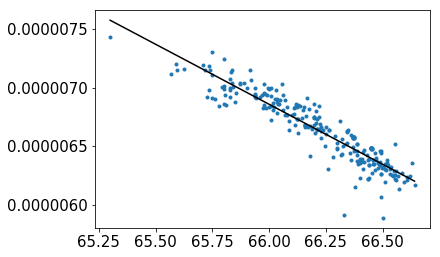

In [859]:
X = sm.add_constant(np.array(GC1))
model = sm.OLS(np.array(genome_length1)/10**6, X)
ols_results = model.fit(cov_type='HC0')
b,a = ols_results.params
plt.plot(np.array(GC1), np.array(genome_length1)/10**6, '.')
Xrange = np.linspace(min(GC1), max(GC1), 1000)
plt.plot(Xrange, a*np.array(Xrange) + b, color = 'black')

In [864]:
# https://towardsdatascience.com/heteroscedasticity-is-nothing-to-be-afraid-of-730dd3f7ca1f
from statsmodels.stats.diagnostic import het_white
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
white_results = het_white(ols_results.resid, X)
dict(zip(keys, white_results))

{'F-statistic:': 0.07558205896612413,
 "F-test's p-value:": 0.9272247365508056,
 "LM test's p-value:": 0.926409057834667,
 'Lagrange Multiplier statistic:': 0.15287878951164435}

In [866]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1419.
Date:                Thu, 26 Mar 2020   Prob (F-statistic):          1.68e-105
Time:                        17:35:42   Log-Likelihood:                 3711.9
No. Observations:                 254   AIC:                            -7420.
Df Residuals:                     252   BIC:                            -7413.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.452e-05    1.8e-06     41.344      0.000     7.1e-05    7.81e-05
x1         -1.025e-06   2.72e-08    -37.667      0.000   -1.08e-06   -9.72e-07
==============================================================================
Omnibus:                       75.619   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.252
Skew:                          -1.227   Prob(JB):                     1.13e-57
Kurtosis:                       7.331   Cond. No.                     1.68e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""